In [1]:
import pandas as pd
import numpy as np
import json
import cobra
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import flux_variability_analysis,moma,add_moma
import pickle
from tqdm import tqdm 
from ast import literal_eval
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import sys
sys.path.append('../retrosynthesis/')

from common import *
# from IgnoreMet import *

### input and output

In [2]:
### input
yeast870_path =  '../../Data/model/yeast-GEM.yml'
yeast8U_path = '../../Data/model/Yeast-MetaTwin.yml'
target_product_file_path = '../../Data/100met_with_smiles.xlsx'
metabolites_info_to_GEM_path = '../../Results/not_lipid/top50_0.3_re/metabolites_info_to_GEM_top50_0.3.csv'
miss_id_path = '../../Data/model/miss_met_id.json'
YMDB_total_smiles_path = '../../Data/ymdb/ymdb_final_result.xlsx'

### output

### native product 

In [3]:
def get_yeast8_metid_for_keggid(model,keggid):
    metid = 'no this met'
    for met in model.metabolites:
        if met.compartment == 'c':
            if 'kegg.compound' in model.metabolites.get_by_id(met.id).annotation:
                if model.metabolites.get_by_id(met.id).annotation['kegg.compound'] == keggid:
                    metid = met.id
    return(metid)

def calculate_FBA(Target_met,model):
    exchange_reaction = get_exchange_reaction(Target_met,model)
    model.objective = model.reactions.get_by_id(exchange_reaction)
    model.optimize()
    ### Remove the added reaction
    if abs(model.reactions.get_by_id(exchange_reaction).flux)>0.001:
        flux_tmp = model.reactions.get_by_id(exchange_reaction).flux
    else:
        flux_tmp = 0
    if 'DM_' in exchange_reaction:
        model.remove_reactions(exchange_reaction)    
    return flux_tmp

def top_three_elements(lst):
    counter = Counter(lst)
    top_three = counter.most_common(3)
    top_three_elements = [item[0] for item in top_three]
    return top_three_elements

def get_subsystem(Target_met,model):
    exchange_reaction = get_exchange_reaction(Target_met,model)
    model.objective = model.reactions.get_by_id(exchange_reaction)
    model.optimize()
    subsystem_list = []
    for i in model.reactions:
        if abs(i.flux)>0.001:
            try:
                subsystem_list.append(i.subsystem[0])
            except: pass

    if 'DM_' in exchange_reaction:
        model.remove_reactions(exchange_reaction)   
    # return subsystem_list
    subsystem_list = [x for x in subsystem_list if 'Transport' not in x and 'Exchange' not in x]
    return top_three_elements(subsystem_list)

def prepare_target_product(target_product_file_path,yeast870_path):
    yeast8 = cobra.io.load_yaml_model(yeast870_path)
    target_product_pd = pd.read_excel(target_product_file_path)
    # target_product_pd.dropna(inplace=True)
    target_product_pd = target_product_pd[target_product_pd['Group'] == 'native']
    target_product_pd['yeast8_id'] = target_product_pd['KEGG ID'].apply(lambda x: get_yeast8_metid_for_keggid(yeast8,x))
    target_product_pd['FBA'] = target_product_pd['yeast8_id'].apply(lambda x : calculate_FBA(x,yeast8))
    target_product_pd = target_product_pd[target_product_pd['FBA']>0.0001]
    target_product_pd['subsystem'] = target_product_pd['yeast8_id'].apply(lambda x : get_subsystem(x,yeast8))
    print(target_product_pd.shape)
    return target_product_pd

In [4]:
target_product_pd = prepare_target_product(target_product_file_path,yeast870_path)
target_product_pd.head()

/home/wuke/anaconda3/envs/kcat/lib/python3.7/site-packages/cobra/core/model.py:777: UserWarning: need to pass in a list
  warn("need to pass in a list")


(52, 11)


,Name,Formula,KEGG ID,CHEBI ID,Group,class,Gene target,Smiles,yeast8_id,FBA,subsystem
0,"2,3-Butanediol",C4H10O2,C03044,16982.0,native,alcohol,Link,NaN,s_0035,1.077151,"[Glycolysis / gluconeogenesis, Glycine, serine..."
1,2-Phenylethanol,C8H10O,C05853,49000.0,native,alcohol,Link,NaN,s_0185,0.544096,"[Glycolysis / gluconeogenesis, Citrate cycle (..."
2,Glycerol,C3H8O3,C00116,17754.0,native,alcohol,Link,NaN,s_0765,1.558928,"[Glycolysis / gluconeogenesis, Citrate cycle (..."
3,Isoamylol,C5H12O,C07328,15837.0,native,alcohol,Link,NaN,s_0929,0.728744,"[Valine, leucine and isoleucine metabolism, Gl..."
4,Isobutanol,C4H10O,C14710,46645.0,native,alcohol,Link,NaN,s_0932,1.000000,"[Glycolysis / gluconeogenesis, Thiamine metabo..."


### byproduct reaction

In [5]:
def get_smiles(metid,model,met_info):
    # print(metid)
    smiles = None
    if metid.startswith('s_'):
        if hasattr(model.metabolites.get_by_id(metid), 'smiles'):
            smiles = model.metabolites.get_by_id(metid).smiles
    elif metid.startswith('sn_'):
        if metid in met_info['ID'].tolist():
            smiles =  met_info[met_info['ID'] == metid]['new_met_smiles'].to_list()[0]
    return smiles

def get_new_smiles_lst_has_carbon(self_smiles,smiles_lst):
    smiles_lst = list(set(smiles_lst))
    smiles_lst = [x for x in smiles_lst if not compare_smiles_inchikey(self_smiles,x)]
    smiles_lst = [x for x in smiles_lst if calculate_carbon_count(x)<=calculate_carbon_count(self_smiles)]
    result = []
    for i in smiles_lst:
        if any(compare_smiles_inchikey(i,j) for j in result):
            pass
        else:
            result.append(i)
    return result

def target_met_in_reaction_lst(target_met,yeast8U):
    reaction_lst = []
    for rea in yeast8U.reactions:
        if target_met in rea.reaction and rea.bounds==(0,1000) and  rea.metabolites[yeast8U.metabolites.get_by_id(target_met)]<0:
            reaction_lst.append(rea.id)
        elif target_met in rea.reaction and rea.bounds==(-1000,0) and  rea.metabolites[yeast8U.metabolites.get_by_id(target_met)]>0:
            reaction_lst.append(rea.id)
        elif target_met in rea.reaction and rea.bounds==(-1000,1000):
            reaction_lst.append(rea.id)
    return reaction_lst

In [6]:
yeast8U = cobra.io.load_yaml_model(yeast8U_path)
yeast8 = cobra.io.load_yaml_model(yeast870_path)
met_info = pd.read_csv(metabolites_info_to_GEM_path)
with open(miss_id_path) as f:
    miss_met_id = json.load(f)

In [7]:
target_product_pd['yeast8_reaction_lst'] = target_product_pd['yeast8_id'].apply(lambda x: target_met_in_reaction_lst(x,yeast8))
target_product_pd['yeast8U_reaction_lst'] = target_product_pd['yeast8_id'].apply(lambda x: target_met_in_reaction_lst(x,yeast8U))
target_product_pd['yeast8_reaction_num'] = target_product_pd['yeast8_reaction_lst'].apply(lambda x:len(x))
target_product_pd['yeast8U_reaction_num'] = target_product_pd['yeast8U_reaction_lst'].apply(lambda x: len(x))

In [8]:
target_100met_df = target_product_pd[['Name','Group','class','yeast8_reaction_lst','yeast8_reaction_num','yeast8U_reaction_lst','yeast8U_reaction_num']]
target_100met_df.head(3)

,Name,Group,class,yeast8_reaction_lst,yeast8_reaction_num,yeast8U_reaction_lst,yeast8U_reaction_num
0,"2,3-Butanediol",native,alcohol,"[r_0003, r_1097]",2,"[r_0003, r_1097, rxn1560]",3
1,2-Phenylethanol,native,alcohol,"[r_0162, r_1590, r_1591]",3,"[r_0162, r_1590, r_1591, rxn46, rxn1092, rxn12...",10
2,Glycerol,native,alcohol,"[r_0487, r_0488, r_1172, r_3597]",4,"[r_0487, r_0488, r_1172, r_3597, rxn289, rxn53...",34


In [9]:
target_100met_df['class'].value_counts()

amino acid                24
organic acid               9
alcohol                    5
fatty acids and lipids     4
alkaloid                   3
other                      3
bioamine                   2
nucleic acid               2
Name: class, dtype: int64

In [ ]:
classes_order = ['nucleic acid', 'bioamine','other','alkaloid','fatty acids and lipids','alcohol','organic acid','amino acid']
target_100met_df = target_100met_df.sort_values(by='class', key=lambda x: pd.Categorical(x, categories=classes_order, ordered=True), na_position='last')
target_100met_df = target_100met_df.groupby('class', sort=False).apply(lambda x: x.sort_values(by='yeast8U_reaction_num', ascending=True)).reset_index(drop=True)
target_100met_df = target_100met_df[target_100met_df['class']!='fatty acids and lipids'].reset_index(drop=True)
target_100met_df.head(3)

,Name,Group,class,yeast8_reaction_lst,yeast8_reaction_num,yeast8U_reaction_lst,yeast8U_reaction_num
0,Thymidine,native,nucleic acid,"[r_2074, r_2075]",2,"[r_2074, r_2075, rxn327, rxn2430, rxn2431, rxn...",7
1,Guanine,native,nucleic acid,"[r_0526, r_0527, r_0949, r_1176, r_1819, r_4758]",6,"[r_0526, r_0527, r_0949, r_1176, r_1819, r_475...",24
2,Spermine,native,bioamine,"[r_0937, r_1262, r_1263, r_1739]",4,"[r_0937, r_1262, r_1263, r_1739, rxn2611]",5


### fig4b

In [11]:
target_100met_df = target_100met_df[::-1].reset_index(drop=True)

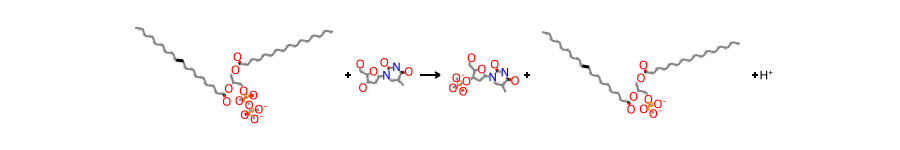

In [12]:
rxndb_total_info_to_model_path = '../../Results/not_lipid/top50_0.3_re/rxndb_total_info_to_model_del2_reaction_top50_0.3.csv'

rxndb_total_info_to_model = pd.read_csv(rxndb_total_info_to_model_path)
rxndb_total_info_to_model.head()

def get_rxn_smiles_final_by_ID(reaID,rxndb_total_info_to_model):
    return rxndb_total_info_to_model[rxndb_total_info_to_model['NO']==reaID]['rxn_smiles_final'].to_list()[0]

rxn_smiles = get_rxn_smiles_final_by_ID('rxn2431',rxndb_total_info_to_model)
reaction = AllChem.ReactionFromSmarts(rxn_smiles)
display(reaction)

In [13]:
def generate_reaction_equation(reaction_dict):
    reactants = []
    products = []
    for metabolite, coefficient in reaction_dict.items():
        if coefficient < 0:
            if abs(coefficient) == 1:
                reactants.append(metabolite)
            else:
                reactants.append(f"{abs(coefficient)} {metabolite}")
        elif coefficient > 0:
            if coefficient == 1:
                products.append(metabolite)
            else:
                products.append(f"{coefficient} {metabolite}")
    
    return " + ".join(reactants) + " => " + " + ".join(products)

reaction_dict = {'(R)-5-diphosphomevalonic acid': -2, '(R)-5-phosphomevalonic acid': 1, 'H+': 10, 'thymidine': -1, "thymidine 3'-monophosphate": 1}
equation = generate_reaction_equation(reaction_dict)
print(equation)

2 (R)-5-diphosphomevalonic acid + thymidine => (R)-5-phosphomevalonic acid + 10 H+ + thymidine 3'-monophosphate


In [14]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import matplotlib.pyplot as plt


def draw_reaction(smiles,figure_path):
    # 定义 SMIRKS 和创建反应对象
    reactant_smiles = smiles.split('>>')[0]
    product_smiles = smiles.split('>>')[1]
    # 创建反应物和产物的分子对象
    reactant_mol = Chem.MolFromSmiles(reactant_smiles)
    product_mol = Chem.MolFromSmiles(product_smiles)

    # 使用 RDKit 绘制分子
    img1 = Draw.MolToImage(reactant_mol)
    img2 = Draw.MolToImage(product_mol)

    # 创建一个新的 matplotlib 图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 8))

    # 在 matplotlib 子图中显示分子图像
    ax1.imshow(img1)
    ax1.set_title('Reactant')
    ax1.axis('off')

    ax2.imshow(img2)
    ax2.set_title('Product')
    ax2.axis('off')

    # 调整子图之间的间距
    plt.tight_layout()

    # 保存图像
    plt.savefig(figure_path, dpi=200, bbox_inches='tight')
    plt.show()

In [15]:
met_info = pd.read_csv(metabolites_info_to_GEM_path)
met_info = met_info[~met_info['ID'].str.contains('s_')]
YMDB_Data = pd.read_excel(YMDB_total_smiles_path)
# YMDB_Data = YMDB_Data[YMDB_Data['in_model']==0]

def process_metinfoID(metinfoID, met_info, YMDB_Data):
    metinfoID_smiles = met_info[met_info['ID'] == metinfoID]['new_met_smiles'].to_list()[0]
    YMDB_ID = []
    for index, row in YMDB_Data.iterrows():
        if compare_smiles_inchikey(metinfoID_smiles, row['SMILES']):
            YMDB_ID.append(row['NAME'])
    if len(YMDB_ID)>0:
        return metinfoID, YMDB_ID[0]
    else:
        return metinfoID, YMDB_ID


ID2name = {}
metinfoID_list = list(set(met_info['ID'].to_list()))
process_partial = partial(process_metinfoID, met_info=met_info, YMDB_Data=YMDB_Data)
with mp.Pool(60) as pool:
    results = list(tqdm(pool.imap_unordered(process_partial, metinfoID_list), total=len(metinfoID_list)))
for metinfoID, YMDB_ID in results:
    ID2name[metinfoID] = YMDB_ID

100%|██████████| 418/418 [03:41<00:00,  1.89it/s]


In [16]:
for i in yeast8U.metabolites:
    if 'sn_' in i.id:
        i.name = str(ID2name[i.id])

In [17]:
for index,row in target_100met_df.iterrows():
    result_df = {'Product name':[],
                'Predicted reaction number':[],
                'Predicted reaction Yeast-MetaTwin ID':[],
                'Predicted reaction':[],
                'Predicted genes of reaction':[]}
    num = 0
    print(row['Name'])
    print(row['yeast8U_reaction_lst'])
    # reaction_lst = [x for x in row['yeast8U_reaction_lst'] if 'r_' not in x]### 这个决定了包不包括新反应
    reaction_lst = [x for x in row['yeast8U_reaction_lst']]### 这个决定了包不包括新反应

    print(reaction_lst)
    for reaction_ID in reaction_lst:
        reaction = yeast8U.reactions.get_by_id(reaction_ID)
        # if any(ID in reaction.reaction for ID in miss_data):
            # pass
        # else:
        num+=1
        print(reaction_ID,reaction.gene_reaction_rule)
        print({k.name:v for k,v in reaction.metabolites.items() if k.name != '[]'})
        reaction_equation = generate_reaction_equation({k.name:v for k,v in reaction.metabolites.items()})
        print(reaction_equation)

        # rxn_smiles = get_rxn_smiles_final_by_ID(reaction_ID,rxndb_total_info_to_model)
        # img_path = f"../Data/Predicted reaction/{row['Name']}_{num}.png"
        # draw_reaction(rxn_smiles,img_path)

        # reaction_mol = AllChem.ReactionFromSmarts(rxn_smiles)
        # img = Draw.ReactionToImage(reaction_mol)
        # img_path = f"../Data/Predicted reaction/{row['Name']}_{num}.png"
        # img.save(img_path)

        result_df['Product name'].append(row['Name'])
        result_df['Predicted reaction number'].append(num)
        result_df['Predicted reaction Yeast-MetaTwin ID'].append(reaction_ID)
        result_df['Predicted reaction'].append(reaction_equation)
        result_df['Predicted genes of reaction'].append(reaction.gene_reaction_rule)
        pd.DataFrame(result_df).to_csv(f"../../Results/byproduct/native/{row['Name']}.csv",index=None)
    print('==========')

L-glutamate
['r_0018', 'r_0026', 'r_0216', 'r_0346', 'r_0460', 'r_0468', 'r_0469', 'r_0470', 'r_0476', 'r_0479', 'r_0538', 'r_0663', 'r_0699', 'r_0851', 'r_0918', 'r_0989', 'r_1031', 'r_1063', 'r_1087', 'r_1118', 'r_1194', 'r_1196', 'r_1659', 'r_1890', 'r_4211', 'r_4212', 'r_4226', 'r_4355', 'r_4572', 'r_4702', 'rxn436', 'rxn448', 'rxn464', 'rxn465', 'rxn468', 'rxn470', 'rxn542', 'rxn696', 'rxn743', 'rxn769', 'rxn806', 'rxn827', 'rxn867', 'rxn936', 'rxn1259', 'rxn1260', 'rxn1261', 'rxn1496', 'rxn1831', 'rxn1854', 'rxn1885', 'rxn1897', 'rxn1910', 'rxn2041', 'rxn2042', 'rxn2155', 'rxn2195', 'rxn2196', 'rxn2260', 'rxn2357', 'rxn2359', 'rxn2366', 'rxn2458', 'rxn2531', 'rxn2545', 'rxn2690', 'rxn2885', 'rxn2951', 'rxn2967', 'rxn2977', 'rxn3029']
['r_0018', 'r_0026', 'r_0216', 'r_0346', 'r_0460', 'r_0468', 'r_0469', 'r_0470', 'r_0476', 'r_0479', 'r_0538', 'r_0663', 'r_0699', 'r_0851', 'r_0918', 'r_0989', 'r_1031', 'r_1063', 'r_1087', 'r_1118', 'r_1194', 'r_1196', 'r_1659', 'r_1890', 'r_4211',